In [1]:
# Decide on what kind of models to use as calibration model - maye be not a linear model?

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit
from sklearn.linear_model import ElasticNet, LinearRegression, SGDRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ExpSineSquared

In [3]:
# import the datafile
validation_preds_and_true_counts = pd.read_csv("True_tassel_counts/validation_true_and_predicted_counts.csv")

In [4]:
validation_preds_and_true_counts.head()

,name,true_count,Predicted_count
0,Block0204_2020_06_29,0,2.103025
1,Block0204_2020_07_01,0,3.598690
2,Block0204_2020_07_02,0,7.005647
3,Block0204_2020_07_06,0,9.229449
4,Block0204_2020_07_07,2,12.557514


In [5]:
validation_preds_and_true_counts.shape

(32, 3)

In [6]:
# Drop the name?
final_data_df = validation_preds_and_true_counts.drop(["name"], axis = 1)

In [7]:
final_data_df.head()

,true_count,Predicted_count
0,0,2.103025
1,0,3.598690
2,0,7.005647
3,0,9.229449
4,2,12.557514


In [8]:
final_data_df.shape

(32, 2)

In [9]:
# rename the columns
final_data_df.columns = ['y_values', 'x_values']

In [10]:
final_data_df.head()

,y_values,x_values
0,0,2.103025
1,0,3.598690
2,0,7.005647
3,0,9.229449
4,2,12.557514


In [11]:
# split the dataframe into train and test sets
X_train, X_test, y_train, y_test = train_test_split(final_data_df['x_values'], final_data_df['y_values'], test_size=0.25, random_state=31)

In [12]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((24,), (24,), (8,), (8,))

In [13]:
X_train = X_train.values.reshape(-1,1)
X_test = X_test.values.reshape(-1,1)
# y_train = y_train.values.reshape(-1,1)
# y_test = y_test.values.reshape(-1,1)

In [14]:
test_fold = [-1] * len(X_train) + [0] * len(X_test)
ps = PredefinedSplit(test_fold=test_fold)

# Combine train and test data into one dataset
X_full = np.concatenate([X_train, X_test])
y_full = np.concatenate([y_train, y_test])

In [15]:
y_full.shape

(32,)

In [16]:
# Okay, now I think we ought to fit multiple models that do the predictions really well. Should we maybe go ahead and plo the true vs predicted values for the train data - may be this will give an idea of what models will be the best

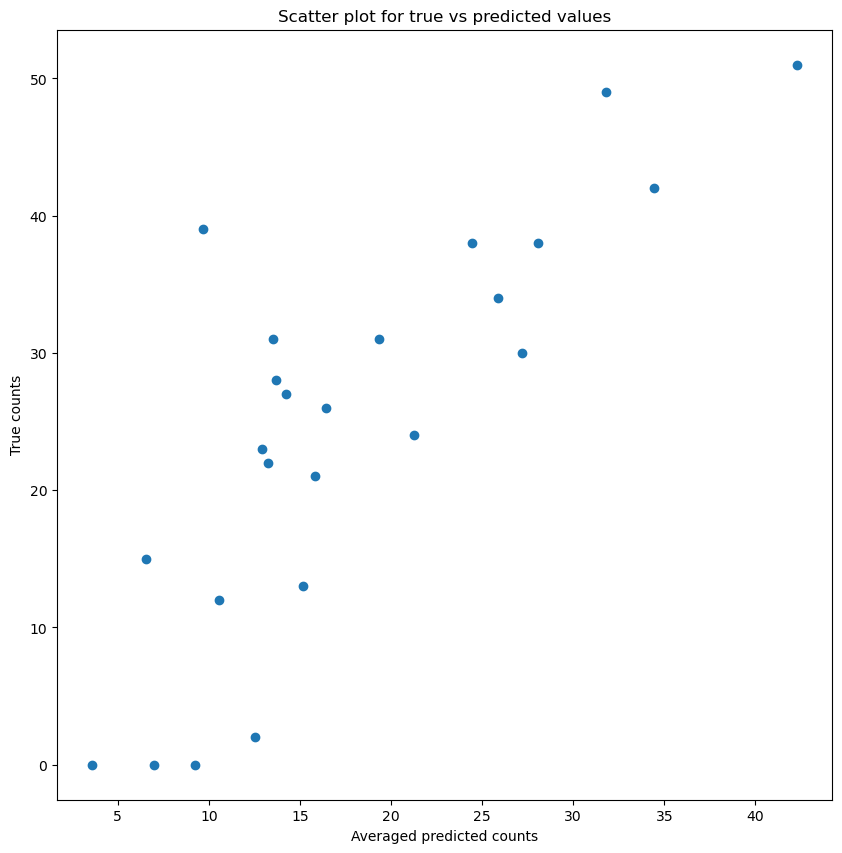

In [17]:
plt.figure(figsize = (10,10))
plt.scatter( X_train, y_train)
plt.title("Scatter plot for true vs predicted values")
plt.xlabel("Averaged predicted counts")
plt.ylabel("True counts")
plt.show()

In [18]:
# well a linear model seems okay - let's start with simple models and also maybe move to a peciptron

In [19]:
# let's try some models with gridsearch

ElasticNet model

In [20]:
# Initialize the ElasticNet model
EN_model = ElasticNet()

In [21]:
# Define the parameter grid
EN_param_grid = {
    'alpha': [0.1, 1.0, 10.0],
    'l1_ratio': [0.1, 0.5, 0.7, 1.0],
    'max_iter': [1000, 2000, 5000]
}

In [22]:
# Set up the GridSearchCV
grid_search_EN = GridSearchCV(estimator=EN_model, param_grid=EN_param_grid, cv=ps, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1, refit=True)

In [23]:
# Fit the grid search to the data
grid_search_EN.fit(X_full, y_full)

Fitting 1 folds for each of 36 candidates, totalling 36 fits


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0])),
             estimator=ElasticNet(), n_jobs=-1,
             param_grid={'alpha': [0.1, 1.0, 10.0],
                         'l1_ratio': [0.1, 0.5, 0.7, 1.0],
                         'max_iter': [1000, 2000, 5000]},
             scoring='neg_mean_squared_error', verbose=1)

In [24]:
# Print the best parameters and best score
print(f"Best parameters found: {grid_search_EN.best_params_}")
print(f"Best score (MSE): {-grid_search_EN.best_score_}")

Best parameters found: {'alpha': 10.0, 'l1_ratio': 0.1, 'max_iter': 1000}
Best score (MSE): 99.99101116117635


In [25]:
# test the values
new_EN_model = ElasticNet(**grid_search_EN.best_params_)

In [26]:
# Fit the grid search to the data
new_EN_model.fit(X_train, y_train)

ElasticNet(alpha=10.0, l1_ratio=0.1)

In [27]:
y_pred = new_EN_model.predict(X_test)

In [28]:
# Get the metrics
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_mae = mean_absolute_error(y_test,y_pred)
test_corr = pearsonr(y_test, y_pred)[0]
test_r2 = r2_score(y_test, y_pred)

In [29]:
test_rmse, test_mae, test_corr, test_r2

(9.99955054795846, 9.168438685676382, 0.7074266458546105, 0.4310105170876424)

In [30]:
test_rmse*test_rmse

99.99101116117635

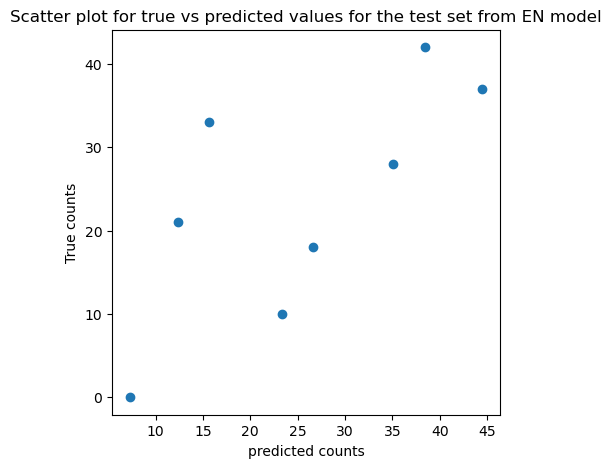

In [31]:
# plot the data test predicted and true values

plt.figure(figsize = (5,5))
plt.scatter( y_pred, y_test)
plt.title("Scatter plot for true vs predicted values for the test set from EN model")
plt.xlabel("predicted counts")
plt.ylabel("True counts")
plt.show()

Linear Regression model

In [32]:
# Initialize the LinearRegression model
LR_model = LinearRegression()

# Define the parameter grid
LR_param_grid = {
    'fit_intercept': [True, False],
    'normalize': [True, False] # normalize was deprecated, removed in sklearn 1.0
}

In [33]:
# Set up the GridSearchCV
LR_grid_search = GridSearchCV(estimator=LR_model, param_grid=LR_param_grid, cv=ps, scoring='neg_mean_squared_error', verbose=2, refit = False)


In [34]:
LR_grid_search.fit(X_full, y_full)

Fitting 1 folds for each of 4 candidates, totalling 4 fits
[CV] END .................fit_intercept=True, normalize=True; total time=   0.0s
[CV] END ................fit_intercept=True, normalize=False; total time=   0.0s
[CV] END ................fit_intercept=False, normalize=True; total time=   0.0s
[CV] END ...............fit_intercept=False, normalize=False; total time=   0.0s


/common/statsgeneral/gayara/tf_with_py38_gpu_29/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
/common/statsgeneral/gayara/tf_with_py38_gpu_29/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this es

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0])),
             estimator=LinearRegression(),
             param_grid={'fit_intercept': [True, False],
                         'normalize': [True, False]},
             refit=False, scoring='neg_mean_squared_error', verbose=2)

In [35]:
# Print the best parameters and best score
print(f"Best parameters found: {LR_grid_search.best_params_}")
print(f"Best cross-validation score (MSE): {-LR_grid_search.best_score_}")

Best parameters found: {'fit_intercept': True, 'normalize': False}
Best cross-validation score (MSE): 110.2669201779102


In [36]:
# test the values
new_LR_model = LinearRegression(**LR_grid_search.best_params_)

In [37]:
# Fit the grid search to the data
new_LR_model.fit(X_train, y_train)

/common/statsgeneral/gayara/tf_with_py38_gpu_29/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


LinearRegression(normalize=False)

In [38]:
y_pred_LR = new_LR_model.predict(X_test)

In [39]:
# Evaluate the best model on the test set
test_rmse_LR = np.sqrt(mean_squared_error(y_test, y_pred_LR))
test_mae_LR = mean_absolute_error(y_test,y_pred_LR)
test_corr_LR = pearsonr(y_test, y_pred_LR)[0]
test_r2_LR = r2_score(y_test, y_pred_LR)

In [40]:
test_rmse_LR, test_mae_LR, test_corr_LR, test_r2_LR

(10.50080569184623, 9.452729395523175, 0.7074266458546106, 0.3725364193663864)

In [41]:
test_rmse_LR*test_rmse_LR

110.26692017791018

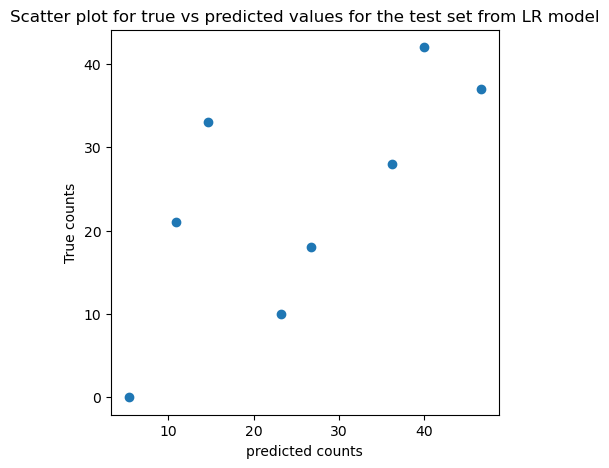

In [42]:
# plot the data test predicted and true values

plt.figure(figsize = (5,5))
plt.scatter(y_pred_LR, y_test)
plt.title("Scatter plot for true vs predicted values for the test set from LR model")
plt.xlabel("predicted counts")
plt.ylabel("True counts")
plt.show()

SVR model

In [43]:
SVR_model = SVR()

In [44]:
SVR_param_grid = {'kernel': ['linear', 'poly'], 'degree': [1,2,3]}

In [45]:
# Set up the GridSearchCV
grid_search_SVR = GridSearchCV(estimator=SVR_model, param_grid=SVR_param_grid, cv=ps, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1, refit=False)

In [46]:
# import sklearn

In [47]:
# sklearn.metrics.get_scorer_names()

In [48]:
# Fit the grid search to the data
grid_search_SVR.fit(X_full, y_full)

Fitting 1 folds for each of 6 candidates, totalling 6 fits


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0])),
             estimator=SVR(), n_jobs=-1,
             param_grid={'degree': [1, 2, 3], 'kernel': ['linear', 'poly']},
             refit=False, scoring='neg_mean_squared_error', verbose=1)

In [49]:
# Print the best parameters and best score
print(f"Best parameters found: {grid_search_SVR.best_params_}")
print(f"Best score (MSE): {-grid_search_SVR.best_score_}")

Best parameters found: {'degree': 1, 'kernel': 'poly'}
Best score (MSE): 100.1939356363464


In [50]:
# test the values
new_SVR_model = SVR(**grid_search_SVR.best_params_)

In [51]:
# Fit the grid search to the data
new_SVR_model.fit(X_train, y_train)

SVR(degree=1, kernel='poly')

In [52]:
y_pred_SVR = new_SVR_model.predict(X_test)

In [53]:
# Evaluate the best model on the test set
test_rmse_SVR = np.sqrt(mean_squared_error(y_test, y_pred_SVR))
test_mae_SVR = mean_absolute_error(y_test,y_pred_SVR)
test_corr_SVR = pearsonr(y_test, y_pred_SVR)[0]
test_r2_SVR = r2_score(y_test, y_pred_SVR)

In [54]:
test_rmse_SVR, test_mae_SVR, test_corr_SVR, test_r2_SVR

(10.009692084991745, 9.17556715073817, 0.7074266458546105, 0.4298557943695057)

In [55]:
test_rmse_SVR*test_rmse_SVR

100.19393563634638

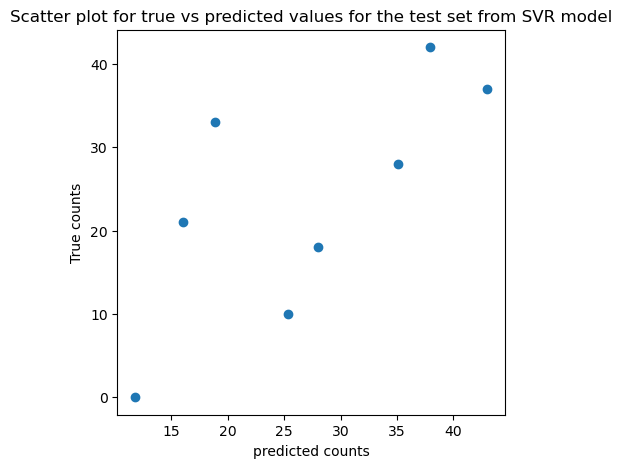

In [56]:
# plot the data test predicted and true values

plt.figure(figsize = (5,5))
plt.scatter(y_pred_SVR, y_test)
plt.title("Scatter plot for true vs predicted values for the test set from SVR model")
plt.xlabel("predicted counts")
plt.ylabel("True counts")
plt.show()

SGDregressor model

In [57]:
# Initialize the SGDRegressor model
SGD_model = SGDRegressor(random_state=42)

# Define the parameter grid
SGD_param_grid = {
    'loss': ['squared_loss', 'huber', 'epsilon_insensitive'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'eta0': [0.001, 0.01, 0.1]}

In [58]:
# Set up the GridSearchCV
SGD_grid_search = GridSearchCV(estimator=SGD_model, param_grid=SGD_param_grid, cv=ps, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

In [59]:
# Fit the grid search to the data
SGD_grid_search.fit(X_full, y_full)

Fitting 1 folds for each of 324 candidates, totalling 324 fits


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0])),
             estimator=SGDRegressor(random_state=42), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01],
                         'eta0': [0.001, 0.01, 0.1],
                         'learning_rate': ['constant', 'optimal', 'invscaling',
                                           'adaptive'],
                         'loss': ['squared_loss', 'huber',
                                  'epsilon_insensitive'],
                         'penalty': ['l2', 'l1', 'elasticnet']},
             scoring='neg_mean_squared_error', verbose=2)

In [60]:
# Print the best parameters and best score
print(f"Best parameters found: {SGD_grid_search.best_params_}")
print(f"Best score (MSE): {-SGD_grid_search.best_score_}")

Best parameters found: {'alpha': 0.001, 'eta0': 0.1, 'learning_rate': 'invscaling', 'loss': 'huber', 'penalty': 'l1'}
Best score (MSE): 105.68574054101865


In [61]:
# test the values
new_SGD_model = SGDRegressor(**SGD_grid_search.best_params_)

In [62]:
# Fit the grid search to the data
new_SGD_model.fit(X_train, y_train)

SGDRegressor(alpha=0.001, eta0=0.1, loss='huber', penalty='l1')

In [63]:
y_pred_SGD = new_SGD_model.predict(X_test)

In [64]:
# Evaluate the best model on the test set
test_rmse_SGD = np.sqrt(mean_squared_error(y_test, y_pred_SGD))
test_mae_SGD = mean_absolute_error(y_test,y_pred_SGD)
test_corr_SGD = pearsonr(y_test, y_pred_SGD)[0]
test_r2_SGD = r2_score(y_test, y_pred_SGD)

In [65]:
test_rmse_SGD, test_mae_SGD, test_corr_SGD, test_r2_SGD

(11.113820897196147, 9.654401825746376, 0.7074266458546106, 0.2971379962801598)

In [66]:
test_rmse_SGD*test_rmse_SGD

123.51701493495378

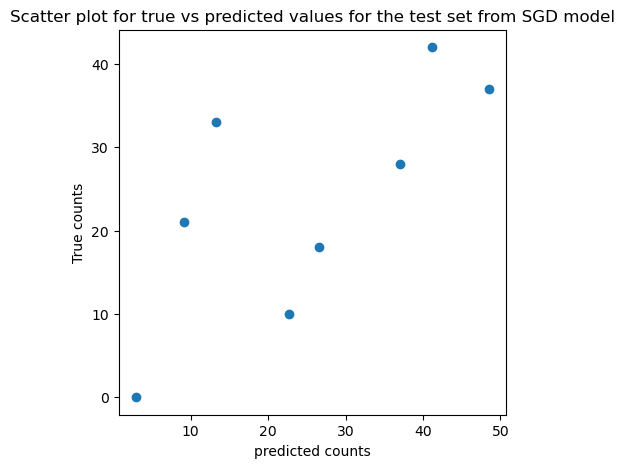

In [67]:
# plot the data test predicted and true values

plt.figure(figsize = (5,5))
plt.scatter(y_pred_SGD, y_test)
plt.title("Scatter plot for true vs predicted values for the test set from SGD model")
plt.xlabel("predicted counts")
plt.ylabel("True counts")
plt.show()

Nearest neighbor regression

In [68]:
# Initialize the KNeighborsRegressor model
NN_model = KNeighborsRegressor()

In [69]:
# Define the parameter grid
NN_param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],           # Number of neighbors to use
    'weights': ['uniform', 'distance'],        # Weight function used in prediction
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], # Algorithm used to compute the nearest neighbors
    'leaf_size': [20, 30, 40],                 # Leaf size for the tree-based algorithms
    'p': [1, 2]                                # Power parameter for the Minkowski metric (1 for Manhattan, 2 for Euclidean)
}

In [70]:
# Set up the GridSearchCV
NN_grid_search = GridSearchCV(estimator=NN_model, param_grid=NN_param_grid, cv=ps, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

In [71]:
# Fit the grid search to the data
NN_grid_search.fit(X_full, y_full)

Fitting 1 folds for each of 240 candidates, totalling 240 fits


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0])),
             estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [20, 30, 40],
                         'n_neighbors': [3, 5, 7, 9, 11], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='neg_mean_squared_error', verbose=2)

In [72]:
# Print the best parameters and best score
print(f"Best parameters found: {NN_grid_search.best_params_}")
print(f"Best score (MSE): {-NN_grid_search.best_score_}")

Best parameters found: {'algorithm': 'brute', 'leaf_size': 20, 'n_neighbors': 3, 'p': 2, 'weights': 'distance'}
Best score (MSE): 65.02672303828268


In [73]:
# test the values
new_NN_model = KNeighborsRegressor(**NN_grid_search.best_params_)

In [74]:
# Fit the grid search to the data
new_NN_model.fit(X_train, y_train)

KNeighborsRegressor(algorithm='brute', leaf_size=20, n_neighbors=3,
                    weights='distance')

In [75]:
y_pred_NN = new_NN_model.predict(X_test)

In [76]:
# Evaluate the best model on the test set
test_rmse_NN = np.sqrt(mean_squared_error(y_test, y_pred_NN))
test_mae_NN = mean_absolute_error(y_test,y_pred_NN)
test_corr_NN = pearsonr(y_test, y_pred_NN)[0]
test_r2_NN = r2_score(y_test, y_pred_NN)

In [77]:
test_rmse_NN, test_mae_NN, test_corr_NN, test_r2_NN

(8.063914870475921, 6.514845628628883, 0.8539366211281236, 0.6299715235662762)

In [78]:
test_rmse_NN*test_rmse_NN

65.0267230382827

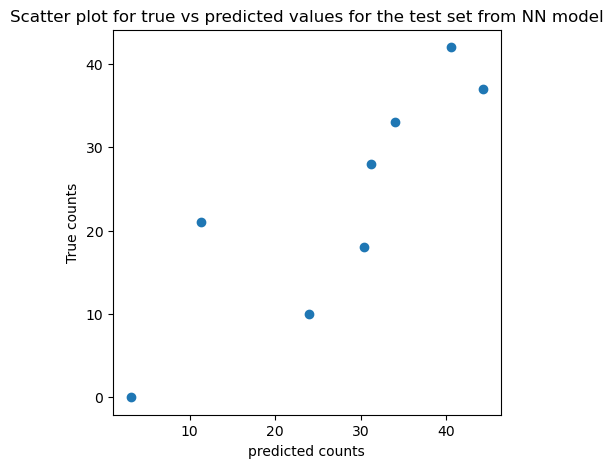

In [79]:
# plot the data test predicted and true values

plt.figure(figsize = (5,5))
plt.scatter( y_pred_NN, y_test)
plt.title("Scatter plot for true vs predicted values for the test set from NN model")
plt.xlabel("predicted counts")
plt.ylabel("True counts")
plt.show()

Gaussian process regression

In [80]:
GPR_model = GaussianProcessRegressor()

# Define the parameter grid
GPR_param_grid = {
    'alpha': [1e-10, 1e-5, 1e-2],  # Noise level added to the diagonal of the kernel matrix
    'kernel': [RBF(length_scale=1.0),          # Radial-basis function (RBF) kernel
               Matern(length_scale=1.0, nu=1.5), # Matern kernel with nu=1.5
               RationalQuadratic(length_scale=1.0, alpha=0.1), # Rational Quadratic kernel
               ExpSineSquared(length_scale=1.0, periodicity=3.0)] # Exponential Sine Squared kernel
}

In [81]:

# Set up the GridSearchCV
GPR_grid_search = GridSearchCV(estimator=GPR_model, param_grid=GPR_param_grid, cv=ps, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)


In [82]:
# Fit the grid search to the data
GPR_grid_search.fit(X_full, y_full)

Fitting 1 folds for each of 12 candidates, totalling 12 fits


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0])),
             estimator=GaussianProcessRegressor(), n_jobs=-1,
             param_grid={'alpha': [1e-10, 1e-05, 0.01],
                         'kernel': [RBF(length_scale=1),
                                    Matern(length_scale=1, nu=1.5),
                                    RationalQuadratic(alpha=0.1, length_scale=1),
                                    ExpSineSquared(length_scale=1, periodicity=3)]},
             scoring='neg_mean_squared_error', verbose=2)

In [83]:
# Print the best parameters and best score
print(f"Best parameters found: {GPR_grid_search.best_params_}")
print(f"Best score (MSE): {-GPR_grid_search.best_score_}")

Best parameters found: {'alpha': 1e-05, 'kernel': RationalQuadratic(alpha=0.1, length_scale=1)}
Best score (MSE): 101.01712173513116


In [84]:
# test the values
new_GPR_model = GaussianProcessRegressor(**GPR_grid_search.best_params_)

In [85]:
# Fit the grid search to the data
new_GPR_model.fit(X_train, y_train)

GaussianProcessRegressor(alpha=1e-05,
                         kernel=RationalQuadratic(alpha=0.1, length_scale=1))

In [86]:
y_pred_GPR = new_GPR_model.predict(X_test)

In [87]:
# Evaluate the best model on the test set
test_rmse_GPR = np.sqrt(mean_squared_error(y_test, y_pred_GPR))
test_mae_GPR = mean_absolute_error(y_test,y_pred_GPR)
test_corr_GPR = pearsonr(y_test, y_pred_GPR)[0]
test_r2_GPR = r2_score(y_test, y_pred_GPR)

In [88]:
test_rmse_GPR, test_mae_GPR, test_corr_GPR, test_r2_GPR

(10.050727423183416, 9.223933070860433, 0.6982467298389925, 0.4251715309817379)

In [89]:
test_rmse_GPR*test_rmse_GPR

101.01712173513114

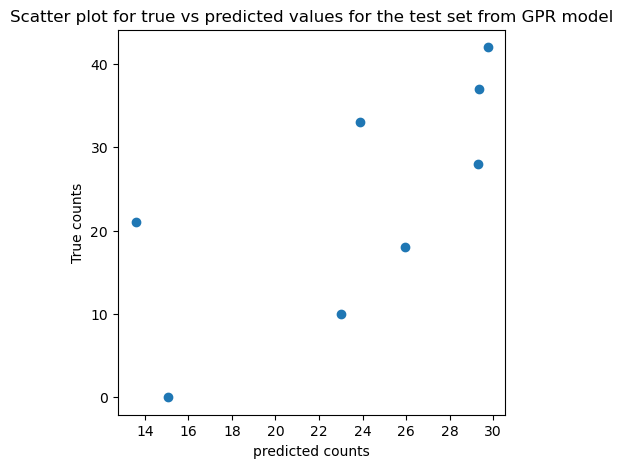

In [90]:
# plot the data test predicted and true values

plt.figure(figsize = (5,5))
plt.scatter( y_pred_GPR, y_test)
plt.title("Scatter plot for true vs predicted values for the test set from GPR model")
plt.xlabel("predicted counts")
plt.ylabel("True counts")
plt.show()

Perceptron

In [16]:
import tensorflow as tf

In [17]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [18]:
# input layer
input_layer = tf.keras.layers.Input(shape = (1,))

In [19]:
# Define the first dense layer
x_1 = tf.keras.layers.Dense(8)

In [20]:
x_1_out = x_1(input_layer)

In [21]:
# add another dense layer
x_2 = tf.keras.layers.Dense(4)

In [22]:
X_2_out = x_2(x_1_out)

In [23]:
pred_head = tf.keras.layers.Dense(1, activation = 'relu')

In [24]:
pred_out = pred_head(X_2_out)

In [25]:
final_model = tf.keras.Model(inputs = input_layer, outputs = pred_out)

In [26]:
final_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense (Dense)               (None, 8)                 16        
                                                                 
 dense_1 (Dense)             (None, 4)                 36        
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________


In [27]:
# define the optimizer for the model
opt = tf.keras.optimizers.Adam(learning_rate = 0.1)

In [28]:
# compile the model
final_model.compile(loss = 'mean_squared_error', optimizer = opt, metrics = ['mean_absolute_error'])

In [29]:
# add early stopping
ES = tf.keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights = True, verbose = 1, patience = 15)

In [30]:
   # # fit the model (fine tuned)
history_new = final_model.fit(X_train, y_train,
          epochs = 300, callbacks = [ES],
          validation_data = (X_test, y_test))


Epoch 1/300
1/1 [==============================] - 1s 1s/step - loss: 126.0350 - mean_absolute_error: 9.5321 - val_loss: 939.6981 - val_mean_absolute_error: 25.7959
Epoch 2/300
1/1 [==============================] - 0s 22ms/step - loss: 628.9852 - mean_absolute_error: 21.5392 - val_loss: 196.4906 - val_mean_absolute_error: 12.9568
Epoch 3/300
1/1 [==============================] - 0s 21ms/step - loss: 104.3816 - mean_absolute_error: 8.1550 - val_loss: 127.9758 - val_mean_absolute_error: 8.2289
Epoch 4/300
1/1 [==============================] - 0s 21ms/step - loss: 145.5632 - mean_absolute_error: 10.4064 - val_loss: 206.2182 - val_mean_absolute_error: 11.5017
Epoch 5/300
1/1 [==============================] - 0s 23ms/step - loss: 253.0683 - mean_absolute_error: 14.0369 - val_loss: 196.4124 - val_mean_absolute_error: 11.1987
Epoch 6/300
1/1 [==============================] - 0s 17ms/step - loss: 240.9535 - mean_absolute_error: 13.6911 - val_loss: 142.0917 - val_mean_absolute_error: 9.018

In [31]:
P_preds = final_model.predict(X_test)

In [32]:
test_rmse_P= np.sqrt(mean_squared_error(y_test, P_preds))
test_mae_P = mean_absolute_error(y_test,P_preds)
test_corr_P = pearsonr(y_test, P_preds)[0]
test_r2_P = r2_score(y_test, P_preds)

In [33]:
test_rmse_P, test_mae_P, test_corr_P, test_r2_P

(10.078719886503968,
 8.374866396188736,
 array([0.7074266519825492], dtype=object),
 0.4219651417054259)

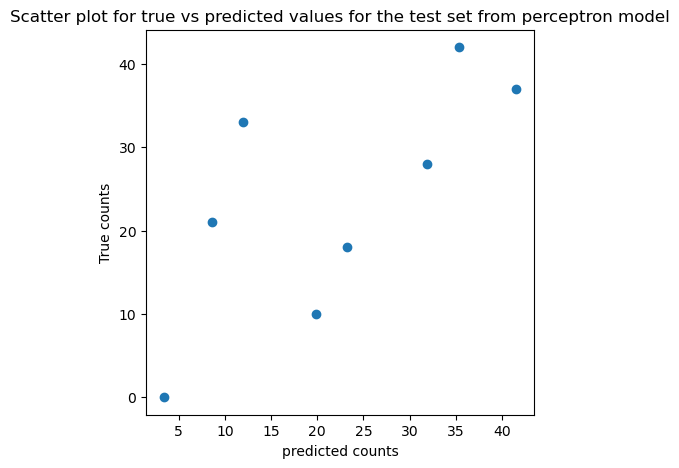

In [34]:
# plot the data test predicted and true values

plt.figure(figsize = (5,5))
plt.scatter( P_preds, y_test)
plt.title("Scatter plot for true vs predicted values for the test set from perceptron model")
plt.xlabel("predicted counts")
plt.ylabel("True counts")
plt.show()

we have a winner - the nearest neighbor model